In [1]:
from SPARQLWrapper import SPARQLWrapper, JSON
from datetime import datetime
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from cdlib import algorithms

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'graph_tool', 'wurlitzer', 'karateclub', 'leidenalg'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'wurlitzer', 'infomap', 'leidenalg'}


In [37]:
def similarita(voti_dep1, voti_dep2):
    uguali = np.sum((voti_dep1 == voti_dep2) & (voti_dep1 != 0) ) # volte in cui hanno votato la stessa  ed erano entrambi presenti
    #print(f'presenti e uguali: {uguali}')
    #entrambi_assenti = np.sum((voti_dep1 == voti_dep2) & (voti_dep1 == 0)) # volte in cui non hanno votato entrambi
    #print((voti_dep1))
    #print((voti_dep2))
    diversi = np.sum((voti_dep1 != voti_dep2) & (voti_dep1 != 0) & (voti_dep2 != 0) ) # volte in cui hanno votato diversamente ed erano entrambi presenti
    #print((voti_dep1 == '0'))
    #print((voti_dep2 == '0'))
    #print(uguali,diversi)
    #almeno_uno_dei_due_assente = np.sum((voti_dep1 == '0') | (voti_dep2 == '0'))
    #print(f'almeno uno dei due assente: {almeno_uno_dei_due_assente}')

    #sim = (uguali)/(numero_votazioni-almeno_uno_dei_due_assente)
    
    if uguali == 0:
        sim = 0
    else:
        sim = uguali/(uguali+diversi)
    return sim

# Load dataset and pre-process, dropping noise rows

In [93]:
feb = pd.read_csv('data/xviii-2021-02.csv')
feb.shape

(660, 78)

In [123]:
nan_count = feb.isnull().sum(axis=1)
p = 0.5
l = len(feb.columns[4:])
df = feb.drop(nan_count[nan_count >= p*l].index, axis = 0)

In [124]:
#mapping to categorical values
dizionario_espressioni = {'Assente': np.float64(0), 'Favorevole': np.float64(1), 'Non ha votato': np.float64(0), 'Contrario': np.float64(3), 'Astensione': np.float64(4), 'In missione': np.float64(0)}
for i in df.columns[4:]:
    df[i] = df[i].map(dizionario_espressioni)

df = df.replace(np.nan, 0)

In [125]:
df.head()

,Parlamentare,id,Partito,dataIngresso,459001,460009,460033,460029,460015,460024,...,461033,461029,461030,461024,461026,461022,462002,462003,462001,462004
0,BASINI GIUSEPPE,200049,LEGA,2018-03-27,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BERSANI PIER LUIGI,300026,MISTO,2018-03-23,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
4,FRANCESCHINI DARIO,300246,PD,2018-03-27,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,CIRIELLI EDMONDO,300319,FDI,2018-03-27,3.0,1.0,3.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,FASANO VINCENZO,300328,FI,2018-03-27,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [126]:
df.reset_index(inplace= True, drop = True)
indici = []
for i in range(df.shape[0]):
    if np.count_nonzero(df.iloc[i,4:]) < 0.7*(df.shape[1]-4):
        indici.append(i)


df.drop(indici, axis = 0, inplace = True)
df.shape

(181, 78)

# Extract party alignment for each voting

In [143]:
#works only with dataframes like ours
def alignment_parties(df):
    col = df.columns[4:].to_list()
    col.append('Partito')
    parties_alignment = pd.DataFrame()
    party = df.groupby('Partito')
    for i in party: # party[0] nome partito, party[1] dataframe
        a = np.apply_along_axis(statistics.mode, axis = 0, arr= i[1])[4:].tolist()
        a.append(i[0])
        parties_alignment = pd.concat([parties_alignment, pd.DataFrame(a).T], axis = 0)

    parties_alignment.columns = col
    return parties_alignment


In [144]:
alignment = alignment_parties(df)
alignment

,459001,460009,460033,460029,460015,460024,460006,460030,460026,460032,...,461030,461024,461026,461022,462002,462003,462001,462004,discipline,Partito
0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,0.8,-SI
0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,CI
0,3.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,FDI
0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,4.0,3.0,3.0,1.0,1.0,0.9866666666666,FI
0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,IPF-IC
0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,4.0,3.0,3.0,1.0,1.0,0.93333333333333,IV-IC'E'
0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,4.0,3.0,3.0,1.0,1.0,0.9466666666666667,LEGA
0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,M5S
0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,0.8666666666,MISTO
0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,0.96,PD


## Partisan discipline

In [ ]:
discipline = []
for index, row in df.iterrows():
    p = alignment[alignment['Partito'] == row['Partito']]
    c = 0
    for i in p.drop('Partito', axis = 1).columns:
        if row[i] == np.float64(p[i][0]):
            c+=1
    
    discipline.append(c/(len(p.columns) - 1))

df['discipline'] = discipline

In [146]:
print(df['discipline'].mean(), df['discipline'].std())

0.8937753222836095 0.13413757855358666


# Graph based on similarity

In [148]:
m = np.array(df[df.columns[4:df.shape[1]-1]])

In [149]:
A = np.zeros((len(m),len(m))) #inizializzo matrice a 0
i=0
j=0
s = []
for i in range(len(m)):
    for j in range(len(m)):
        A[i,j] = similarita(m[i, 3:],m[j, 3:])
        if (i>j): 
            s.append(similarita(m[i, 3:],m[j, 3:]))

In [150]:
unique_scores, counts = np.unique(A, return_counts=True)
distribution = dict(zip(unique_scores, counts / np.sum(counts)))

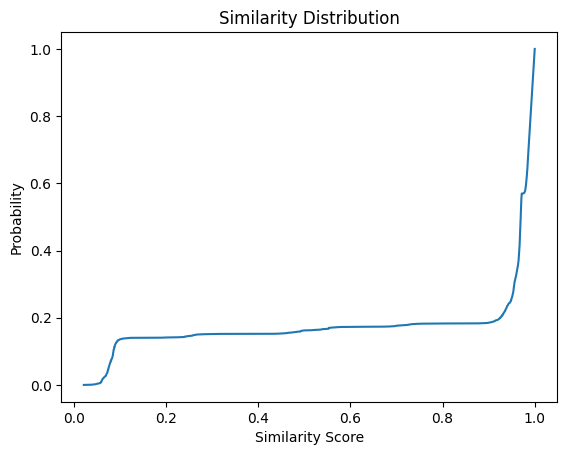

In [151]:
scores = list(distribution.keys())
probabilities = np.cumsum(list(distribution.values()))

plt.plot(scores, probabilities)
plt.xlabel('Similarity Score')
plt.ylabel('Probability')
plt.title('Similarity Distribution')
plt.show()

In [152]:
num_nodes = A.shape[0]
graph = nx.Graph()
threshold = 0.7

for i in range(num_nodes):
    graph.add_node(i)  # Add nodes to the graph


for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        weight = A[i, j]
        if np.abs(weight) >= threshold:
            graph.add_edge(i, j)  #Add edges to the graph with weight attribute


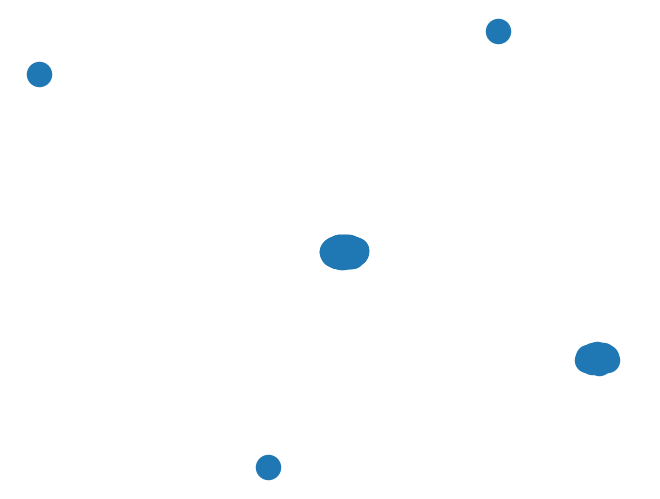

In [153]:
nx.draw(graph)

In [154]:
print(len(graph.nodes), len(graph.edges))

181 13415


In [155]:
louvain = algorithms.louvain(graph)

In [156]:
louvain.communities

[[0,
  1,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  64,
  65,
  66,
  67,
  68,
  69,
  71,
  72,
  73,
  74,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  87,
  88,
  89,
  90,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  105,
  106,
  107,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  122,
  123,
  124,
  125,
  126,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  141,
  142,
  143,
  144,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  158,
  159,
  160,
  161,
  162,
  163,
  164,
  165,
  166,
  167,
  168,
  169,
  170,
  171,
  172,
 

In [157]:
louvain.average_internal_degree(summary=False)

[162.4878048780488, 13.0, 0.0, 0.0, 0.0]

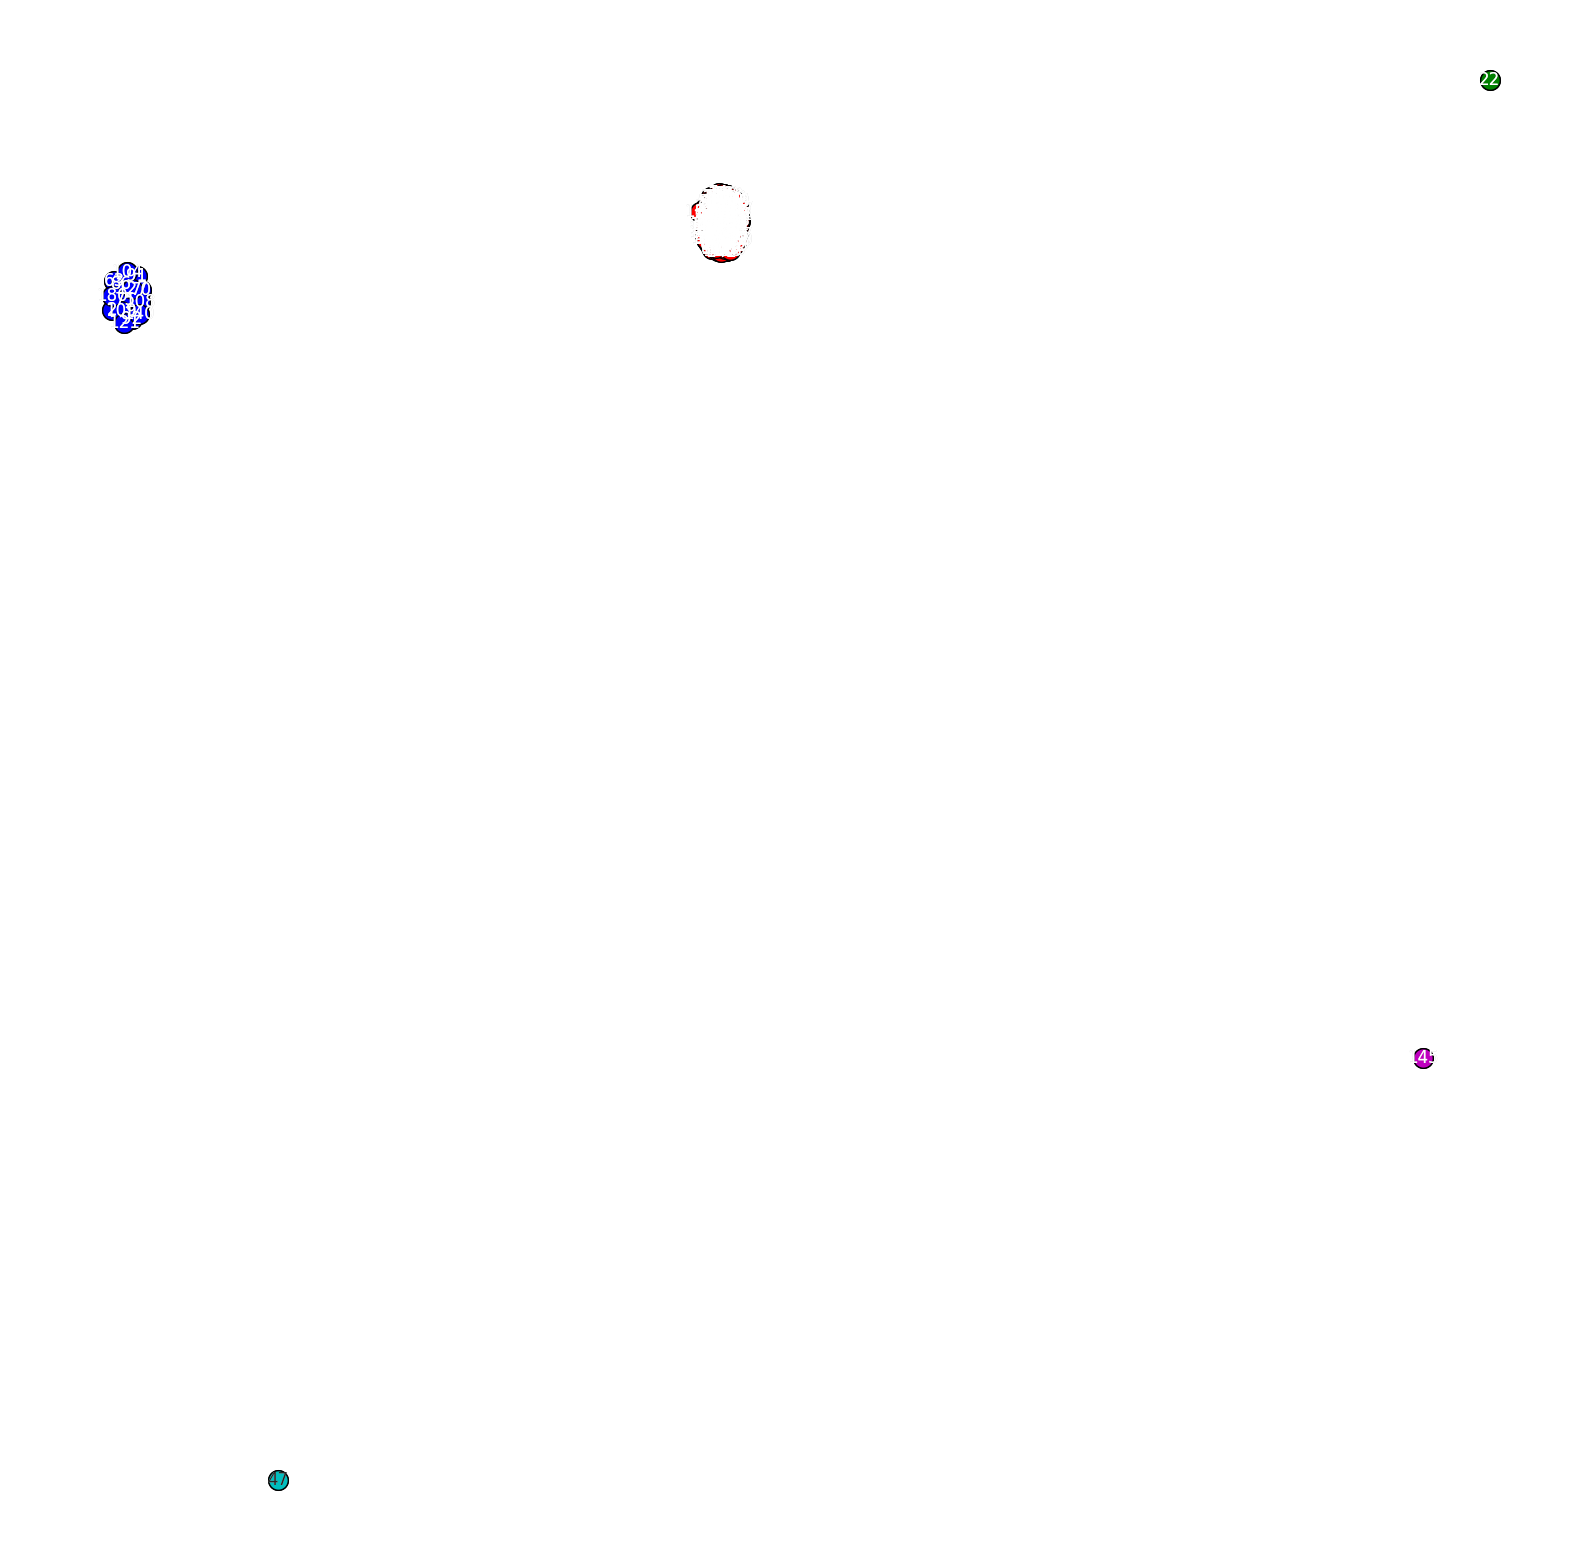

In [158]:
from cdlib import viz

pos = nx.spring_layout(graph)
viz.plot_network_clusters(graph, louvain, pos, figsize=(20, 20), plot_labels=True)